In [1]:
import numpy as np
import qiskit as q
from qiskit import *
from qiskit.tools.jupyter import *
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from qiskit.tools.jupyter import *
from scipy.optimize import minimize
from sklearn.preprocessing import Normalizer

from qiskit import BasicAer
from qiskit.ml.datasets import *
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM, VQC

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit,execute
from qiskit_jku_provider import JKUProvider
from numpy import pi

from sklearn.datasets import load_iris # import Iris data set 
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize # import a normilisation function 
np.random.seed(42) # set a seed

ModuleNotFoundError: No module named 'qiskit_jku_provider'

In [2]:
iris = datasets.load_iris()
x = iris.data[:, :4]  # we only take the first two features.
Y = iris.target


In [3]:
#x, Y = load_iris().data, load_iris().target 
x, Y = shuffle(x,Y)

# take the first 5
x = x[:5] 
Y = Y[:5]

In [4]:
print(x,Y)

[[6.1 2.8 4.7 1.2]
 [5.7 3.8 1.7 0.3]
 [7.7 2.6 6.9 2.3]
 [6.  2.9 4.5 1.5]
 [6.8 2.8 4.8 1.4]] [1 0 2 1 1]


In [5]:
#noramlise the data
data = normalize(x)
print(data)

[[0.73659895 0.33811099 0.56754345 0.14490471]
 [0.8068282  0.53788547 0.24063297 0.04246464]
 [0.70600618 0.2383917  0.63265489 0.21088496]
 [0.73350949 0.35452959 0.55013212 0.18337737]
 [0.76467269 0.31486523 0.53976896 0.15743261]]


In [6]:
featuremap_circ = ZFeatureMap(4, reps=1)

In [7]:
print(featuremap_circ)

     ┌───┐┌──────────────┐
q_0: ┤ H ├┤ U1(2.0*x[0]) ├
     ├───┤├──────────────┤
q_1: ┤ H ├┤ U1(2.0*x[1]) ├
     ├───┤├──────────────┤
q_2: ┤ H ├┤ U1(2.0*x[2]) ├
     ├───┤├──────────────┤
q_3: ┤ H ├┤ U1(2.0*x[3]) ├
     └───┘└──────────────┘


In [8]:
circ_data0 = featuremap_circ.assign_parameters(data[0]/1)

In [9]:
#More generally, ...
circ = QuantumCircuit(4) 
for i in range(len(data)):
    circ = circ.combine(featuremap_circ.assign_parameters(data[i]/2)) 
print(circ)

     ┌───┐┌──────────────────────┐┌───┐ ┌──────────────────────┐┌───┐»
q_0: ┤ H ├┤ P(0.736598948602255) ├┤ H ├─┤ P(0.806828202995202) ├┤ H ├»
     ├───┤├──────────────────────┤├───┤ ├──────────────────────┤├───┤»
q_1: ┤ H ├┤ P(0.338110992801035) ├┤ H ├─┤ P(0.537885468663468) ├┤ H ├»
     ├───┤├──────────────────────┤├───┤ ├──────────────────────┤├───┤»
q_2: ┤ H ├┤ P(0.567543452201738) ├┤ H ├─┤ P(0.240632972823130) ├┤ H ├»
     ├───┤├──────────────────────┤├───┤┌┴──────────────────────┤├───┤»
q_3: ┤ H ├┤ P(0.144904711200444) ├┤ H ├┤ P(0.0424646422629054) ├┤ H ├»
     └───┘└──────────────────────┘└───┘└───────────────────────┘└───┘»
«     ┌──────────────────────┐┌───┐┌──────────────────────┐┌───┐»
«q_0: ┤ P(0.706006178920718) ├┤ H ├┤ P(0.733509487318909) ├┤ H ├»
«     ├──────────────────────┤├───┤├──────────────────────┤├───┤»
«q_1: ┤ P(0.238391696778424) ├┤ H ├┤ P(0.354529585537472) ├┤ H ├»
«     ├──────────────────────┤├───┤├──────────────────────┤├───┤»
«q_2: ┤ P(0.632654887604280) ├┤

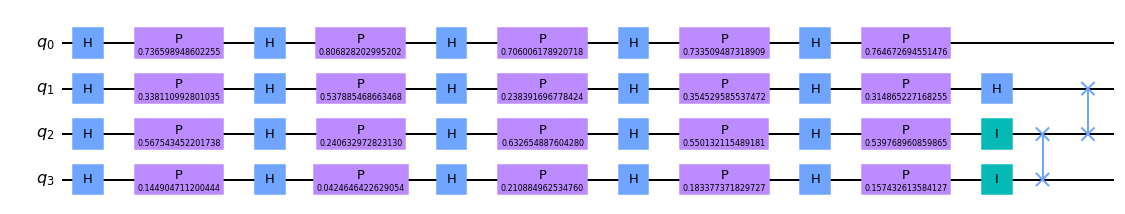

In [10]:
#SWAP gate to move the data to q1, for knn processing 
circ.h([1])
circ.id([2])
circ.id([3])
circ.swap([2], [3])
circ.swap([1], [2])

circ.draw(output="mpl")

In [11]:
# encoding into a subroutine 
n = 4
FMap = QuantumCircuit(n,name='FMap')

circ = QuantumCircuit(4) 
for i in range(len(data)):
    circ = circ.combine(featuremap_circ.assign_parameters(data[i]/2)) 

circ.swap([2], [3])
circ.swap([1], [2])


FMap= circ
print(FMap)

FMap.to_gate()

     ┌───┐┌──────────────────────┐┌───┐ ┌──────────────────────┐┌───┐»
q_0: ┤ H ├┤ P(0.736598948602255) ├┤ H ├─┤ P(0.806828202995202) ├┤ H ├»
     ├───┤├──────────────────────┤├───┤ ├──────────────────────┤├───┤»
q_1: ┤ H ├┤ P(0.338110992801035) ├┤ H ├─┤ P(0.537885468663468) ├┤ H ├»
     ├───┤├──────────────────────┤├───┤ ├──────────────────────┤├───┤»
q_2: ┤ H ├┤ P(0.567543452201738) ├┤ H ├─┤ P(0.240632972823130) ├┤ H ├»
     ├───┤├──────────────────────┤├───┤┌┴──────────────────────┤├───┤»
q_3: ┤ H ├┤ P(0.144904711200444) ├┤ H ├┤ P(0.0424646422629054) ├┤ H ├»
     └───┘└──────────────────────┘└───┘└───────────────────────┘└───┘»
«     ┌──────────────────────┐┌───┐┌──────────────────────┐┌───┐»
«q_0: ┤ P(0.706006178920718) ├┤ H ├┤ P(0.733509487318909) ├┤ H ├»
«     ├──────────────────────┤├───┤├──────────────────────┤├───┤»
«q_1: ┤ P(0.238391696778424) ├┤ H ├┤ P(0.354529585537472) ├┤ H ├»
«     ├──────────────────────┤├───┤├──────────────────────┤├───┤»
«q_2: ┤ P(0.632654887604280) ├┤

In [12]:
#base circuit
q       = QuantumRegister(9)
c       = ClassicalRegister(9)
circuit = QuantumCircuit(q,c)

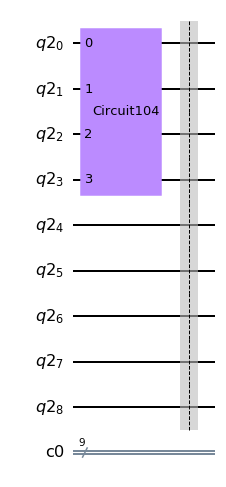

In [13]:
# conjoin the two circuits in a way, by adding the subroutine to the 
#base circuit

circuit.append(FMap,[0,1,2,3])


circuit.barrier()

#circuit.id([1])
#circuit.id([2])
#circuit.id([3])
#circuit.swap([2], [3])
#circuit.swap([1], [2])
#circuit.barrier()

circuit.draw(output="mpl")

In [14]:
n = 9
kNN = QuantumCircuit(n,name='kNN')

kNN.h(0) 
kNN.h(1)

kNN.id(4)
kNN.id(5)
kNN.id(6)
kNN.id(7)
kNN.id(8)

kNN.x(3)#The NOT gate, also known as the Pauli X gate, flips the  state to , and vice versa. 
kNN.cx(1, 3)

kNN.id(4)
kNN.cx(0, 2)
kNN.id(5)
kNN.id(6)
kNN.id(7)
kNN.id(8)

kNN.id(3)
kNN.id(4)
kNN.id(5)
kNN.id(5)
kNN.id(7)
kNN.id(8)



####

kNN.id(0)
kNN.id(1)

kNN.x(2)
kNN.x(3)
kNN.x(4)

kNN.id(5)

kNN.x(6)

kNN.id(7)
kNN.id(8)

#kNN.barrier()


###


kNN.ccx(2, 3, 4)

kNN.id(6)
kNN.id(7)
kNN.id(8)


kNN.ccx(2, 5, 6)

kNN.id(7)
kNN.id(8)


kNN.ccx(2, 6, 5)


kNN.id(7)
kNN.id(8)


kNN.x(6)
          
#circuit.id(qreg_q[2])



kNN.id(5)
kNN.id(7)
kNN.id(8)

#kNN.barrier

######

kNN.ccx(3, 5, 4)



kNN.id(6)
kNN.id(7)
kNN.id(8)



kNN.ccx(3, 5, 6)

kNN.id(7)
kNN.id(8)

kNN.ccx(3, 6, 5)

kNN.id(7)
kNN.id(8)



kNN.x(6)


#circuit.id(qreg_q[3])
#circuit.id(qreg_q[4])


#circuit.id(qreg_q[5])
kNN.id(7)
kNN.id(8)


#####
#kNN.barrier()
kNN.x(4)
kNN.x(5)
kNN.x(6)

kNN.ccx(4, 5,7)
kNN.ccx(6, 7, 8)

kNN.x(8)

kNN.to_gate()

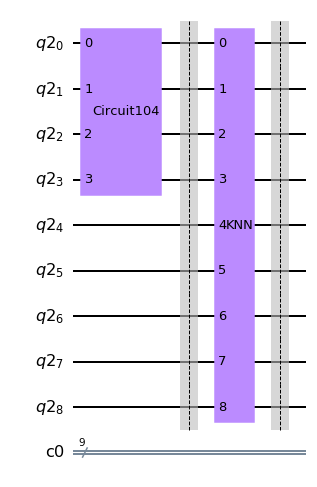

In [15]:
circuit.append(kNN,[0,1,2,3,4,5,6,7,8])
circuit.barrier()


circuit.draw(output="mpl")

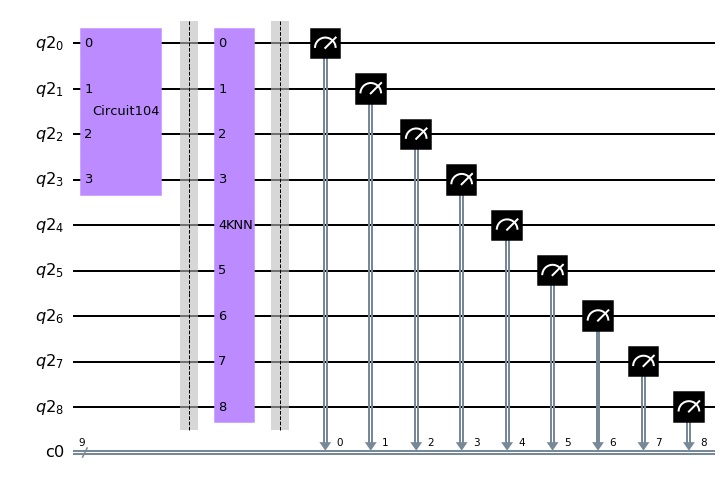

In [16]:
circuit.measure([0,1,2,3,4,5,6,7,8], [0,1,2,3,4,5,6,7,8])



circuit.draw(output="mpl")

In [17]:
from qiskit.visualization import plot_histogram

In [18]:
emulator = Aer.get_backend('qasm_simulator')

job = execute( circuit, emulator, shots=8192 )

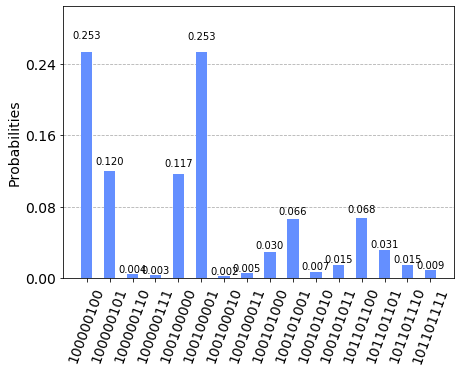

In [19]:
hist = job.result().get_counts()
plot_histogram(hist)

In [20]:
IBMQ.active_account()

In [21]:
IBMQ.save_account('b35ee002c40b58f68333b4dc663e57f118764a66394591bc1270dd258ede51076296505fe28203f55935798b133fda9814350ca6b975b3899b38cbda9a034725', overwrite=True)

In [22]:
IBMQ.load_account()
provider= IBMQ.get_provider(hub='ibm-q')
real_device = provider.get_backend('ibmq_16_melbourne')

/Users/ezi/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [37]:
job = execute(circuit, backend = real_device, shots=8192)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

603839f8ca306c56012b47e2
Job Status: job has successfully run


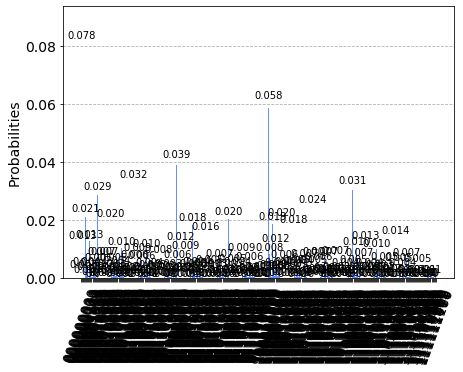

In [24]:
device_result = job.result()
plot_histogram(device_result.get_counts(circuit))

In [ ]:
#-----------reduce noise------

In [25]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [41]:
 cal_circuits ,state_labels = complete_meas_cal(qr = circuit.qregs[0], circlabel= 'measerrormitigational')

In [ ]:
# gives a series of calibrtion erroes to run

In [31]:
len(cal_circuits) # how many circuits

512

In [43]:
import os
os.environ['QISKIT_IN_PARALLEL'] = "True"  # pretends the code already runs in parallel

In [46]:
properties = real_device.properties()
coupling_map = real_device.configuration().coupling_map

In [47]:
from qiskit.providers.aer.noise import NoiseModel

noise_model = NoiseModel.from_backend(properties)

In [53]:
job = execute(circuit, backend = real_device, shots=1050, 
                    optimization_level =2)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

6038474fe1cffbd93772fa28
Job Status: job incurred error    


In [44]:
cal_job =execute(cal_circuits,backend= real_device,shots= 1024,
                 optimization_level =2 # makes sure cuircuits aerenot changed as we transfer them from here to real device
                
                )
print(cal_job.job_id())
job_monitor(job)
cal_result = cal_job.result()

603845b546d2a040bf063699
Job Status: job has successfully run


IBMQJobFailureError: 'Unable to retrieve result for job 603845b546d2a040bf063699. Job has failed: The number of experiments in the Qobj (512) is higher than the number of experiments supported by the device (75). Error code: 1102.'

In [ ]:
plot_histogram(cal_result.get_counts(cal_circuits[3])
)

In [ ]:
meas_fitter =CompleteMeasFitter(cal_results, state_labels)

In [ ]:
meas_fitter.plot_calibration()

In [ ]:
meas_filter = meas_fitter.filter

In [ ]:
mitigated_result = meas_filter.apply(device_result)

In [ ]:
device_counts = device_result.get_counts(circuit)
mitgated_counts = mitgated_result.get_counts(circuit)
plot_histogram([device_counts, mitgated_counts], legend=['device, noisy', 'device, mitigated'])

In [ ]:
#---------------------classical simulation------

In [26]:
from qiskit_jku_provider import JKUProvider
#pip install qiskit-jku-provider
JKU = JKUProvider()

ModuleNotFoundError: No module named 'qiskit_jku_provider'

In [27]:
jku_backend = JKU.get_backend(‘qasm_simulator’)
job = execute(qc, backend=jku_backend, shots=1024, seed=42)
result = job.result()
print(result.get_counts())

SyntaxError: invalid character in identifier (<ipython-input-27-61b7840e690a>, line 1)

In [28]:
# Get the JKU backend from the JKU provider
jku_backend = JKU.get_backend('qasm_simulator')

# Simulate the circuit with the JKU Simulator
job = execute(qc, backend=jku_backend)

# Retrieve and display the results
result = job.result()
print(result.get_counts(qc))

NameError: name 'JKU' is not defined